In [1]:
!git clone https://github.com/Juanchumu/TpLabDatos.git

Cloning into 'TpLabDatos'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 328.42 KiB | 2.86 MiB/s, done.


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.metrics import mean_squared_error

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

# Configuración warnings
# ==============================================================================
import warnings

print(f"Versión de scikit-learn: {sklearn.__version__}")

Versión de scikit-learn: 1.6.1


In [12]:
ruta_archivo = "TpLabDatos/DB/Grupo 4 - Precio de viviendas.csv"
# cargar la versión CSV:
datos = pd.read_csv(ruta_archivo, sep=',', encoding='utf-8')
datos = datos.drop(columns=['Order', 'PID'])
datos.head(3)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [13]:
datos.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [15]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'SalePrice'), #TRAIN
                                        datos['SalePrice'], #TEST
                                        random_state = 123
                                    )

# Ordinal encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# HistGradientBoostingClassifier requiere que los valores de categoría se codifiquen
# en [0, n_unique_categories - 1], por lo que se utiliza un OrdinalEncoder para
# preprocesar los datos. Los valores missing se codifican como -1. Si una nueva
# categoría se encuentra en el conjunto de test se codifica como -1.
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
preprocessor = make_column_transformer(
                        (
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            cat_cols
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
# X_train_prep = preprocessor.fit_transform(X_train)
# X_test_prep  = preprocessor.transform(X_test)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2197 entries, 2441 to 1346
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS Zoning        2197 non-null   int64  
 1   Street           2197 non-null   int64  
 2   Alley            2197 non-null   int64  
 3   Lot Shape        2197 non-null   int64  
 4   Land Contour     2197 non-null   int64  
 5   Utilities        2197 non-null   int64  
 6   Lot Config       2197 non-null   int64  
 7   Land Slope       2197 non-null   int64  
 8   Neighborhood     2197 non-null   int64  
 9   Condition 1      2197 non-null   int64  
 10  Condition 2      2197 non-null   int64  
 11  Bldg Type        2197 non-null   int64  
 12  House Style      2197 non-null   int64  
 13  Roof Style       2197 non-null   int64  
 14  Roof Matl        2197 non-null   int64  
 15  Exterior 1st     2197 non-null   int64  
 16  Exterior 2nd     2197 non-null   int64  
 17  Mas Vnr Type    

##Ajuste del modelo

Se ajusta un modelo empleando como variable respuesta MEDV y como predictores todas las otras variables disponibles.

La clase HistGradientBoostingRegressor del módulo sklearn.ensemble permite entrenar modelos Gradient Boosting para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

loss='squared_error'

quantile=None

learning_rate=0.1

max_iter=100

max_leaf_nodes=31

max_depth=None

min_samples_leaf=20

l2_regularization=0.0

max_bins=255

categorical_features=None

monotonic_cst=None

interaction_cst=None

warm_start=False

early_stopping='auto'

scoring='loss'

validation_fraction=0.1

n_iter_no_change=10

tol=1e-07

verbose=0

random_state=None

Puede encontrarse una descripción detallada de todos ellos en sklearn.ensemble.GradientBoostingRegressor. En la práctica, cabe prestar especial atención a aquellos que controlan el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar overfitting:

learning_rate: reduce la contribución de cada árbol multiplicando su influencia original por este valor.

max_iter: número de árboles incluidos en el modelo.

max_depth: profundidad máxima que pueden alcanzar los árboles.

min_samples_leaf: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

max_leaf_nodes: número máximo de nodos terminales que pueden tener los árboles.

early_stopping: Si es 'auto', se activa la parada temprana si el tamaño de la muestra es superior a 10000. Si es True, se activa la parada temprana; en caso contrario, se desactiva.

validation_fraction: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (early stopping).

n_iter_no_change: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (early stopping). Si su valor es None se desactiva la parada temprana.

tol: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.

random_state: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

In [17]:

# Creación del modelo
# ==============================================================================
modelo = HistGradientBoostingRegressor(
            max_iter     = 10,
            loss         = 'squared_error',
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=10, random_state=123)

### Predicción y evaluación del modelo

Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test.

In [18]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print(f"El error (RMSE) de test es: {rmse:.2f}")
#5.18 es el error que va a tener, osea mas menos el valor predicho

El error (RMSE) de test es: 37888.81


### Optimización de hiperparámetros

El modelo inicial se ha entrenado utilizando 10 árboles (max_iter=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

#### Número de árboles

En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, con forme se añaden árboles, se incrementa el riesgo de sobreajuste (overfitting).

Valor óptimo de n_estimators: 476


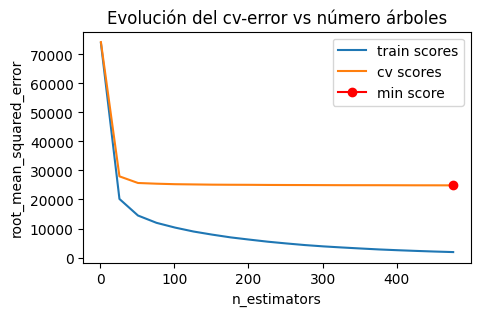

In [19]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_iter_range = range(1, 500, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for max_iter in max_iter_range:

    modelo = HistGradientBoostingRegressor(
                max_iter     = max_iter,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = np.sqrt(mean_squared_error(y_train, predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1,
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_iter_range, train_scores, label="train scores")
ax.plot(max_iter_range, cv_scores, label="cv scores")
ax.plot(max_iter_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {max_iter_range[np.argmin(cv_scores)]}")

Los valores estimados por validación cruzada muestran que, a partir de los 50 árboles, el error del modelo se estabiliza, consiguiendo un mínimo con 251 árboles.

#### Learning rate

Junto con el número de árboles, el learning_rate es el hiperparámetro más importantes en Gradient Boosting, ya que es el que permite controlar cómo de rápido aprende el modelo y con ello el riesgo de llegar al overfitting. Estos dos hiperparámetros son interdependientes, cuanto menor es el learning rate, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting.

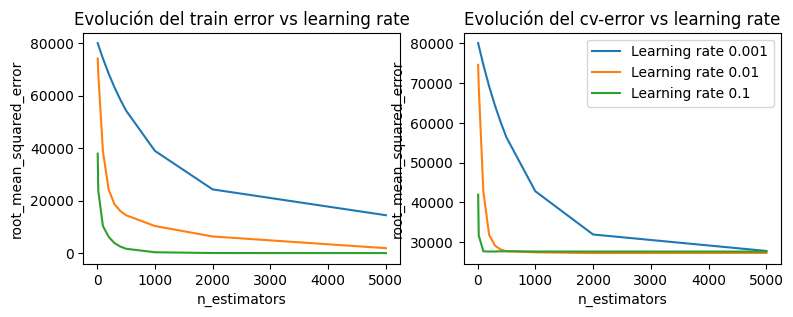

In [20]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
resultados = {}

# Valores evaluados
learning_rates_grid = [0.001, 0.01, 0.1]
max_iter_grid   = [10, 20, 100, 200, 300, 400, 500, 1000, 2000, 5000]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates_grid:
    train_scores = []
    cv_scores    = []

    for n_estimator in max_iter_grid:

        modelo = HistGradientBoostingRegressor(
                    max_iter      =  n_estimator,
                    learning_rate = learning_rate,
                    random_state  = 123
                 )

        # Error de train
        modelo.fit(X_train, y_train)
        predicciones = modelo.predict(X = X_train)
        rmse = np.sqrt(mean_squared_error(y_train, predicciones))
        train_scores.append(rmse)

        # Error de validación cruzada
        scores = cross_val_score(
                    estimator = modelo,
                    X         = X_train,
                    y         = y_train,
                    scoring   = 'neg_root_mean_squared_error',
                    cv        = 3,
                    n_jobs    = multiprocessing.cpu_count() - 1
                 )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(-1*scores.mean())

    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráfico con la evolución de los errores de entrenamiento
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

for key, value in resultados.items():
    axs[0].plot(max_iter_grid, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate")

    axs[1].plot(max_iter_grid, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate")
    plt.legend();

Puede observarse que, cuanto mayor es el valor del learning rate, más rápido aprende el modelo pero antes puede aparecer el overfitting. En este caso, los errores estimados por validación cruzada indican que, el mejor modelo se consigue con un learning rate de 0.1.

#### Max depth

La profundidad de los árboles (max_depth) en los modelos Gradient Boosting suele ser un valor muy bajo, haciendo así que cada árbol solo pueda aprender un pequeña parte de la relación entre predictores y variable respuesta (weak learner).

Valor óptimo de max_depth: 10


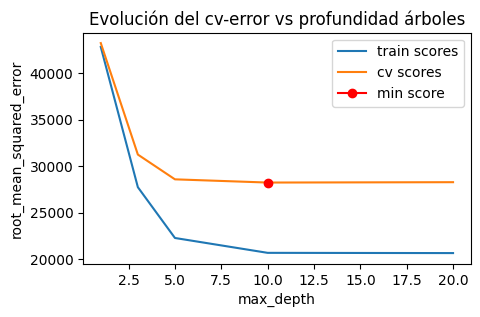

In [21]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [1, 3, 5, 10, 20]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:

    modelo = HistGradientBoostingRegressor(
                max_iter     = 25,
                max_depth    = max_depth,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = np.sqrt(mean_squared_error(y_train, predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = multiprocessing.cpu_count() - 1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

### Grid search


Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros.

Cuando los recursos computacionales (o tiempo) son limitados, es aconsejable seguir una de las siguientes estrategias para identificar los hiperparámetros óptimos de un modelo Gradient Boosting:

Fijar el número de árboles y optimizar el learning rate.

Fijar el learning rate y añadir tantos árboles como sea necesario pero activando la parada temprana para evitar overfitting.

Una vez identificados los valores de estos hiperparámetros, se refinan el resto.

#### Grid Search basado en validación cruzada

En la siguiente búsqueda de hiperparámetros, se emplea la estrategia de no incluir el número de árboles como hiperparámetro en el grid. En su lugar, se utiliza por defecto un número muy elevado y se activa la parada temprana.

En las implementaciones nativas de scikit-learn (GradientBoosting y HistGradientBoosting), el conjunto de validación para la parada temprana se extrae automáticamente de los datos de entrenamiento utilizados en cada ajuste, por lo que puede integrarse directamente en el GridSearchCV() o RandomizedSearchCV().

In [22]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'loss'             : ['squared_error', 'absolute_error'],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'max_depth'        : [3, 5, 10, 20],
              'l2_regularization': [0, 1, 10]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000,
                        random_state        = 123,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_l2_regularization,param_learning_rate,param_loss,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
58,10,0.01,squared_error,10,-26313.436049,5020.370734,-15940.152782,1590.812615
59,10,0.01,squared_error,20,-26376.597181,5100.274990,-15101.373320,1975.424765
11,0,0.01,squared_error,20,-26459.910000,5675.910080,-15448.892587,1714.031327
67,10,0.10,squared_error,20,-26472.935336,5224.365658,-14397.721025,2158.119041


In [23]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'l2_regularization': 10, 'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 10} : -26313.436048863532 neg_root_mean_squared_error


In [24]:
# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_iter_}")

Número de árboles del modelo: 1000


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [25]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 23376.116002885785


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 5.2 a 4.1. Las predicciones del modelo final se alejan en promedio 4.1 unidades (4100 dólares) del valor real.

### Importancia de predictores

HistGradientBoostingRegressor ya no incorpora la importancia de los predictores basándose en la pureza de nodos por las evidencias de que esta forma de calcular la importancia está altamente influenciada por el número de predictores utilizados. En su lugar, se recomienda el uso del método de permutación.

In [26]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
46,30486.138643,576.716905,Overall Qual
58,19387.344884,391.461366,Gr Liv Area
68,6433.750802,210.993406,Garage Cars
54,4973.492035,76.509466,Total Bsmt SF
55,4923.490500,191.777475,1st Flr SF
...,...,...,...
5,0.000000,0.000000,Utilities
40,0.000000,0.000000,Misc Feature
38,0.000000,0.000000,Pool QC
73,0.000000,0.000000,3Ssn Porch


<ipython-input-28-172ccd97bb84>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


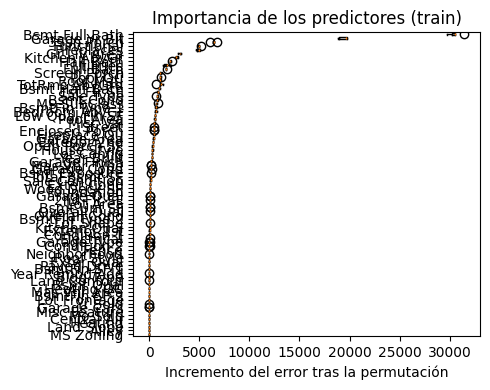

In [28]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 4))
sorted_idx = importancia.importances_mean.argsort()
ax.boxplot(
        importancia.importances[sorted_idx].T,
        vert   = False,
        labels = datos.drop(columns = "SalePrice").columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout();

Ambas estrategias identifican LSTAT y RM como los predictores más influyentes, acorde a los datos de entrenamiento.

## XGBoost y LighGBM


### XGBoost

A diferencia de las implementaciones nativas de scikit-learn, en XGBoost y LightGBM, el conjunto de validación para la parada temprana, no se extrae automáticamente. Para poder integrar la parada temprana con el GridSearchCV() o RandomizedSearchCV() y que no haya observaciones que participan en ambos procesos, se tiene que separar manualmente un conjunto de validación del de entrenamiento.

In [29]:
# Instalación XGBoost: pip install xgboost
from xgboost import XGBRegressor

In [32]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Crear conjunto de validación
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size=int(X_train.shape[0]*0.1), #10% de los datos de entrenamiento
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {
              "eval_set": [(X_val, y_val)],
              "verbose": False
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators          = 1000,
                        early_stopping_rounds = 5,
                        eval_metric           = "rmse",
                        random_state          = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
12,gbtree,0.01,None,0.5,-24775.889974,2492.954247,-10632.482422,96.119495
29,gbtree,0.10,3,1.0,-24817.609375,1736.830313,-13994.391927,1133.017000
20,gbtree,0.01,10,0.5,-25020.885417,2472.954105,-6861.623372,558.136878
22,gbtree,0.01,20,0.5,-25049.395182,2498.862412,-5827.131999,918.963235


In [33]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Número de árboles del modelo final (early stopping)
#xgb_model.get_score(importance_type="gain")
# ==============================================================================
n_arboles_incluidos = len(grid.best_estimator_.get_booster().get_dump())
print(f"Número de árboles incluidos en el modelo: {n_arboles_incluidos}")

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': None, 'subsample': 0.5} : -24775.889973958332 neg_root_mean_squared_error
Número de árboles incluidos en el modelo: 568


In [34]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 21603.887057657008


## LightGBM

Para este ejemplo, se incorpora en la búsqueda el número de árboles en lugar de activar la parada temprana.

In [35]:
# Instalación LightGBM: pip install lightgbm
from lightgbm.sklearn import LGBMRegressor

In [36]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000, 5000],
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
71,gbdt,0.01,3,5000,1.0,-25302.607230,1996.948114,-8846.798305,343.953563
70,gbdt,0.01,3,5000,0.5,-25302.607230,1996.948114,-8846.798305,343.953563
116,gbdt,0.10,3,1000,0.5,-25450.234581,2115.070596,-5089.026716,285.638958
117,gbdt,0.10,3,1000,1.0,-25450.234581,2115.070596,-5089.026716,285.638958


In [37]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5000, 'subsample': 0.5} : -25302.60722991876 neg_root_mean_squared_error


In [38]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test,)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 21939.704739402434
